# Neural nets with Back-Propagation, this time with Pytorch

This notebook contains a complete implementation of a neural network this time implemented with Pytorch. 

I advise you to work through the notebook first, and seek to understand the code.  After that, go back to the places where I suggest activities, and try to implement these. 

AFTER GOING THROUGH THIS NOTEBOOK you will be ready to go to the textbooks by Smola or Howard, and work through the slightly more complicated implementations there.  (We will be doing MNIST and MNIST Fashion next week...) 

### Aims of this session: 

*  To understand how to implement a simple neural network in Pytorch 

*  To explore the structure of the Pytorch model, and examine the weights and the initialisation

*  To explore many more variations of the network using Pytorch to greatly speed things up


In [2]:
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt
# the next instruction makes the plots appear within the notebook
%matplotlib inline

First we want some data.

Our data will be points in the plane. We will generate random points within a square, like so:  

In [4]:
X = 2 * np.random.random((100,2)) - 1
# points in a square [-1,1] (random samples from Unif(0,1))
# you can re-run with more or fewer than 200 training data points 

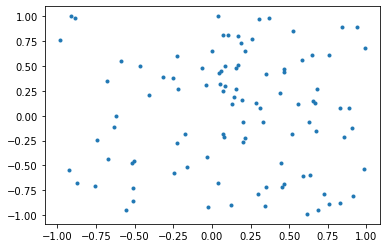

In [5]:
plt.plot(X[:,0],X[:,1],'.')

* We want to do classification, that is, predict one of the possible classes for every data point
* So, we define below some classifiers

In [6]:
def classifier2(X):# a circle centered at 0,0 with radius 0.66
    return (np.sum( X * X, axis=1) < 0.66 ).astype(float)

In [7]:
def classifier3(X): # a 3x2 checkerboard pattern
    return (( np.ceil((3/2)*(X[:,0]+1)).astype(int) + np.ceil( X[:,1]+1).astype(int) ) %2).astype(float)

In [8]:
def classifier4(X): # a 4x4 checkerboard pattern -- you can use the same method to make up your own checkerboard patterns
    return (np.sum( np.ceil( 2 * X).astype(int), axis=1 ) % 2).astype(float)

In [9]:
# let's use classifier 3
Y = classifier3( X ) 

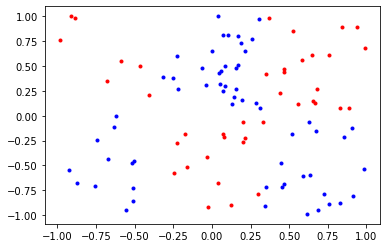

In [10]:
# let's visualize them
# X[Y==0.0,] means "get all the rows of X where Y is 0". X[Y==0.0,0] gets the first coordinate
plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

We have a highly non-linear function

In [11]:
X.shape 

(100, 2)

In [12]:
Y.shape

(100,)

# Doing it with Pytorch

Last week's program was a little painful: we had to construct the neural network and all of the gradients ourselves, and then check them. 

Is there an easier way? After all, many people have built neural networks before. 


In [13]:
import torch
import torch.nn as nn  # various types of layers
import torch.nn.functional as F  # activation functions, among other things

### How to create a NN in pytorch?
we extend (create a subclass of) pytorch's `nn.Module` class (https://pytorch.org/docs/stable/generated/torch.nn.Module.html). 

In [14]:
class Net1( nn.Module ): 
    
    # here one typically initialises the layers
    # self is reference to the object (class instance)
    def __init__(self):
        super(Net1,self).__init__() # call constructor of super calls
        # two linear layers
        # this layer has 24 neurons/outputs and 2 inputs
        self.layer1 = nn.Linear(2,24) 
        # this layer has 1 neuron and 24 inputs
        self.layer2 = nn.Linear(24,1) # these automatically define the weights and biases for the layers
        
    # we need to define this to tell the net how to evaluate forward pass    
    def forward(self,x):
        
        # any input x has 2 components, so it has dimension (n,2) (n is batch size)
        # layer 1 is a tensor (matrix) of weights of dimension (2,24) (+ a vector of 24 biases)
        # self.layer1(x) is = x*layer1_weights + layer1_biases, and so has dimensions (n,24)
        x = torch.relu(self.layer1(x))
        # self.layer2 has dimension (24,1); its input has (n,24) and so, 
        # output dimension is (n,1)
        # sigmoid squashes in between 0 and 1
        x = torch.sigmoid(self.layer2(x))
        return x 

In [15]:
# create an instance of our network class
# it is initialised with random weights, and it needs training
net1 = Net1()
print( net1 )

Net1(
  (layer1): Linear(in_features=2, out_features=24, bias=True)
  (layer2): Linear(in_features=24, out_features=1, bias=True)
)


In [16]:
net1.parameters() # generator object

<generator object Module.parameters at 0x7fba53fda430>

In [17]:
list( net1.parameters() )

[Parameter containing:
 tensor([[-0.3793,  0.2926],
         [-0.3284, -0.0093],
         [ 0.1173, -0.1614],
         [-0.4231,  0.2186],
         [ 0.4956,  0.4419],
         [-0.2887,  0.2225],
         [ 0.2970, -0.4802],
         [-0.3543, -0.4258],
         [-0.4275,  0.5580],
         [-0.4371, -0.1381],
         [ 0.4033, -0.2724],
         [-0.5106, -0.6112],
         [-0.3661,  0.6953],
         [ 0.1034,  0.4190],
         [-0.0546,  0.1747],
         [-0.1094, -0.1623],
         [ 0.6101,  0.1897],
         [ 0.0253,  0.3687],
         [ 0.5304, -0.0746],
         [-0.2080, -0.6212],
         [-0.4134,  0.3342],
         [ 0.5264, -0.6132],
         [ 0.3489,  0.5383],
         [ 0.1800, -0.2232]], requires_grad=True),
 Parameter containing:
 tensor([-0.3817, -0.0121, -0.5469,  0.2035, -0.3613,  0.0195,  0.5322, -0.6504,
          0.0957, -0.2159, -0.3339,  0.1296,  0.3600,  0.0861, -0.2678,  0.1611,
          0.6573, -0.2974, -0.6544, -0.2875, -0.3795,  0.3235, -0.0241,  0

* _We have indeed 2x24 weights, 1x24 biases, 24x1 weights and 1x1 bias._ To exclude bias, just pass `bias=False` to `nn.Linear` (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear)
* `requires_grad` true by default

That's it! That is our feedforward specification of our previous NN2layer model!
All of the back-propagation will by compiled implicitly. 

In [18]:
# translate our numpy array into a torch tensor
X_tensor = torch.FloatTensor(X) # X is a double in numpy, we need float32
X_tensor.dtype

torch.float32

In [19]:
X_tensor.shape

torch.Size([100, 2])

In [20]:
Y_tensor = torch.FloatTensor(Y)
Y_tensor.dtype

torch.float32

In [21]:
Y_tensor.shape

torch.Size([100])

In [22]:
# let's compute the output of the neural net
# zero any gradients before doing forward pass (if previous gradients are present)
# by default, torch accumulates gradients in subsequent "backward" calls, see https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
net1.zero_grad() 
output = net1(X_tensor)
output.shape

torch.Size([100, 1])

The target values (Y) need to be the same shape as the output before we compute the average loss (this is why one needs to be careful about always knowing the shape of one's tensors). Let's reshape Y to be like the output, therefore. 

In [23]:
Y_like_output = Y_tensor.reshape([100,1])
Y_like_output.shape

torch.Size([100, 1])

In [24]:
# we also need to specify the loss function we will use 
# In this case, binary cross-entropy (suitable for 2 class classifaction using
# the output of a sigmoid layer), aka logistic loss
loss = nn.BCELoss() 

In [25]:
average_loss = loss( output, Y_like_output)
average_loss 

tensor(0.7192, grad_fn=<BinaryCrossEntropyBackward>)

In [26]:
average_loss.backward() # let's now compute the gradients

Now what do we do with the gradients?  Instead of writing our own code to update the weights by gradient descent, we will use an Optimizer object, one of the ones provided by pytorch. RMSProp is a nice, stable choice.  

This will take the parameters, with their attached gradients which have been calculated after `average_loss.backward()`, and then update the weights (sensibly) in the direction of the gradient. 

Let us first create the optimizer object.

In [27]:
# In order to train it, we construct an instance of an optimizer class 
# which contains our network's parameters (given as a generator)
optimizer = torch.optim.RMSprop( net1.parameters() ) 

In [28]:
# now actually use the optimizer to update the weights
optimizer.step()
# that's it - the weights have been adjusted! We can train again... 

Parameters have changed

In [29]:
list(net1.parameters())

[Parameter containing:
 tensor([[-0.4793,  0.3926],
         [-0.4284, -0.1093],
         [ 0.1173, -0.1614],
         [-0.5231,  0.3185],
         [ 0.5956,  0.3421],
         [-0.3886,  0.3224],
         [ 0.3970, -0.3802],
         [-0.3543, -0.4258],
         [-0.5275,  0.6580],
         [-0.3371, -0.0381],
         [ 0.3033, -0.1724],
         [-0.4106, -0.7112],
         [-0.2661,  0.5953],
         [ 0.2033,  0.3190],
         [-0.0546,  0.1747],
         [-0.2094, -0.0623],
         [ 0.7101,  0.0897],
         [ 0.1246,  0.2688],
         [ 0.5304, -0.0746],
         [-0.1081, -0.5212],
         [-0.3134,  0.2342],
         [ 0.4264, -0.7132],
         [ 0.4482,  0.4384],
         [ 0.0801, -0.1232]], requires_grad=True),
 Parameter containing:
 tensor([-0.2817,  0.0879, -0.5469,  0.3035, -0.2613,  0.1195,  0.4322, -0.6504,
          0.1957, -0.3159, -0.4339,  0.2296,  0.2600, -0.0139, -0.2678,  0.0611,
          0.7573, -0.3950, -0.6544, -0.3875, -0.4795,  0.4235, -0.1240,  0

If we evaluate our net again (forward pass), we should see a lower (better) loss

In [30]:
net1.zero_grad() 
output = net1(X_tensor)
average_loss = loss( output, Y_like_output)
average_loss 

tensor(0.6619, grad_fn=<BinaryCrossEntropyBackward>)

## Basic structure of deep learning program
Well, we have just written our neural net, cell by cell. Let's gather all the code together, into two phases: __setup__ and __training__. 

### Setting up the net

In [31]:
# this defines our network as a subclass of nn.Module 

class Net1( nn.Module ): 
    
    def __init__(self):
        super(Net1,self).__init__()
        self.layer1 = nn.Linear(2,24)
        self.layer2 = nn.Linear(24,1) # these automatically define the weights and biases for the layers
        
    def forward(self,x):
        x = torch.relu(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x 

In [32]:
# create an instance of our network class
# it is initialised with random weights, and it needs training

net1 = Net1()
print( net1 )

Net1(
  (layer1): Linear(in_features=2, out_features=24, bias=True)
  (layer2): Linear(in_features=24, out_features=1, bias=True)
)


In [33]:
# we also need to specify the loss function we will use 
# In this case, binary cross-entropy (suitable for 2 class classifaction using
# the output of a sigmoid layer). 

loss_function = nn.BCELoss()

In [34]:
# In order to train it, we construct an instance of an optimizer class 
# which contains our network's parameters (given as a generator)

optimizer = torch.optim.RMSprop( net1.parameters() )

### Training the net

 Our training data is `X_tensor` (the inputs) and `Y_like_outpu`t ( the target classifications that we want our network to achieve).
 
 We reshaped `Y_like_output` to have the same shape as the output of our network (a little trial and error there...) 

In [43]:
n_epochs = 20 ## number of training steps

In [44]:
for i in range(0,n_epochs): 

    net1.zero_grad() # zero all gradients in the network
    # before doing back-propagation
    # It is important to remember to zero the gradients, 
    # otherwise the gradients will 
    # just accumulate. 
    
    output = net1( X_tensor ) # forward pass
    
    average_loss = loss_function( output, Y_like_output)
    
    print(i, average_loss.item()) # important to see what is happening
    # average_loss is a zero-dimensional tensor; to convert it to a number 
    # we cannot index, but instead we do average_loss.item() 
    
    average_loss.backward() # this computes all our gradients :) 
    
    optimizer.step() # this updates the weights :) 

0 0.45634129643440247
1 0.44781696796417236
2 0.4395277500152588
3 0.43193477392196655
4 0.4242614507675171
5 0.41686156392097473
6 0.40979576110839844
7 0.40309062600135803
8 0.3960898518562317
9 0.3895988464355469
10 0.3824796676635742
11 0.37616780400276184
12 0.3691922426223755
13 0.3631833791732788
14 0.356868177652359
15 0.3507753014564514
16 0.34490737318992615
17 0.3397538363933563
18 0.3341657221317291
19 0.32918012142181396
20 0.32420554757118225
21 0.31947752833366394
22 0.3148650825023651
23 0.3104354739189148
24 0.3057752847671509
25 0.3014991879463196
26 0.29698115587234497
27 0.2926785349845886
28 0.28841209411621094
29 0.2843547761440277
30 0.28025132417678833
31 0.27649298310279846
32 0.27251023054122925
33 0.2689399719238281
34 0.2655433714389801
35 0.26208847761154175
36 0.2585964500904083
37 0.2553160786628723
38 0.252149760723114
39 0.24916061758995056
40 0.24610798060894012
41 0.2431662678718567
42 0.2401706874370575
43 0.2373783439397812
44 0.2346651405096054
45 

___Why a 2d input/function?___ because we can visualize what happens (impossible for realistic high-dimensional neural nets)

In [37]:
def plot_nn_predictions( net1 ):
    # build a grid of x-values and y-values in our domain
    x_values = np.linspace(-1,1,200)
    y_values = np.linspace(-1,1,200)
    # initialize 200x200 grid to store results
    J_grid = np.zeros([x_values.size,y_values.size])    
    
    # We do something interesting here.  
    # By calling torch.no_grad(), we are telling pytorch we are not interested in computing gradients 
    # so in the forward pass, it spares us extra computation/memory required for backprop
    with torch.no_grad(): 
        # for every point in our 200x200 grid
        for x_index in range(0, x_values.size):
            for y_index in range(0, y_values.size):
                # we evaluate our net on the individual (x,y) point of the grid and update J_grid with the prediction
                predicted_y_tensor =net1(torch.FloatTensor([x_values[x_index], y_values[y_index]]))
                J_grid[x_index,y_index] = predicted_y_tensor.item()
        
    # plot the grid + legend
    plt.imshow(J_grid.transpose(), origin='lower',extent=[-1,1,-1,1])
    plt.colorbar()                                               

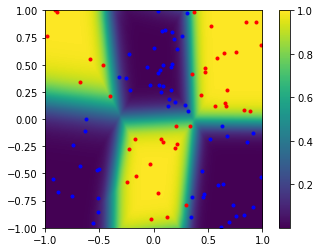

In [45]:
# plot the predictions and overlay our training data
plot_nn_predictions(net1)

plt.plot(X[Y==0.0,0],X[Y==0.0,1],'b.')
plt.plot(X[Y==1.0,0],X[Y==1.0,1],'r.')

__Ideas for improvement__:
the `plot_nn_predictions` function is rather slow because the  model is being used to make one prediction at a time. This incurs quite a large overhead: it is more efficient to make many predictions at once. Can you modify this function to do this? 

### How can we examine the weights and the gradients? 

Simple !  We can extract them from the neural network. 

Our network `net1` has two inputs, 24 neurons in the first layer, and 1 neuron in the output layer. 

The first layer is called `layer1` and the second `layer2` (go back and look at the definition of the class `Net1`)

In [ ]:
net1.layer1 ## first layer 

In [ ]:
net1.layer1.weight # weights of first layer

In [39]:
# a small complication here. We want to convert the weight tensor to 
# a numpy array, but it has gradients attached. If requires_gradient is True, 
# we must use .detach().numpy() instead of just .numpy()
# (returns a new tensor detached from current graph )

layer1_weights = net1.layer1.weight.detach().numpy()
layer1_weights

array([[ 1.1174295 ,  0.6251254 ],
       [-1.2184495 ,  0.86079764],
       [-1.0487441 ,  0.7124148 ],
       [-0.7119812 ,  0.7871565 ],
       [ 0.86336595,  0.51461923],
       [-0.80990946, -0.41824985],
       [ 1.172268  ,  0.6371612 ],
       [ 0.12411237, -0.00877335],
       [ 0.02406028,  0.45592964],
       [ 1.1616496 ,  0.69208705],
       [-0.9889342 ,  0.9532409 ],
       [ 1.1174295 , -0.8564963 ],
       [ 0.11291336, -0.3928969 ],
       [-1.0062408 ,  0.66701573],
       [ 1.0353541 , -1.0660962 ],
       [-1.0115503 , -0.62325174],
       [-0.6398772 ,  0.8580159 ],
       [ 0.0398466 , -0.5984993 ],
       [ 0.44756785, -0.43366876],
       [ 0.34126195,  0.20931087],
       [-1.0121801 , -0.53693795],
       [ 0.08259663, -0.34622926],
       [ 0.02786092,  0.18932132],
       [ 0.9655756 ,  0.5520521 ]], dtype=float32)

In [40]:
# we don't need to use detach for the gradients because the gradients are a 
# pure tensor. 

layer1_gradients = net1.layer1.weight.grad.numpy()
layer1_gradients

array([[-7.8737680e-03, -5.4870485e-03],
       [ 1.1630061e-02, -5.5172443e-03],
       [ 1.1560832e-02, -5.4844031e-03],
       [ 3.7877660e-03, -1.3182508e-03],
       [-1.1990400e-03,  5.6788384e-05],
       [ 3.1633927e-03, -1.5423258e-03],
       [-5.0628195e-03, -3.5281628e-03],
       [-1.3406284e-04, -4.6122260e-04],
       [ 0.0000000e+00,  0.0000000e+00],
       [-9.4424030e-03, -6.5801945e-03],
       [ 5.1214695e-03, -8.5386261e-04],
       [-5.9306421e-03,  1.7125171e-04],
       [-1.1054508e-05, -3.8031249e-05],
       [ 1.0980153e-02, -6.9166683e-03],
       [-8.3224159e-03, -7.2633848e-05],
       [ 2.4345119e-03,  1.6675000e-03],
       [ 3.2754843e-03,  7.4857962e-04],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00],
       [ 2.9799150e-05,  1.0251955e-04],
       [ 7.6104570e-03, -3.7105128e-03],
       [-5.3114496e-04, -3.9850129e-04],
       [ 3.4540892e-05,  1.1883263e-04],
       [-9.4316471e-03, -6.5727010e-03]], dtype=float32)

Let's now plot some histograms of weights and gradients

(array([ 8.,  4.,  4.,  8.,  5., 10.,  9.]),
 array([-3.5579665 , -2.6488416 , -1.7397165 , -0.8305916 ,  0.07853334,
         0.9876583 ,  1.8967832 ,  2.8059082 ], dtype=float32),
 <BarContainer object of 7 artists>)

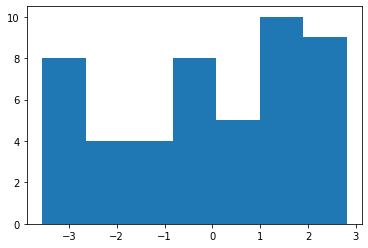

In [46]:
n_bins = 7
plt.hist( layer1_weights.reshape(-1), n_bins )

(array([ 4.,  4.,  3.,  6., 16.,  7.,  8.]),
 array([-0.00704471, -0.0054528 , -0.0038609 , -0.00226899, -0.00067708,
         0.00091482,  0.00250673,  0.00409864], dtype=float32),
 <BarContainer object of 7 artists>)

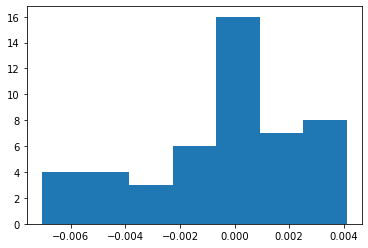

In [47]:
n_bins = 7 
plt.hist( layer1_gradients.reshape(-1), n_bins )

__let's now train more and see what happens!__

# More exercises: vary the network and explore the effects

Your task in this lab is to explore as many variations as possible using Pytorch. 

Try adding more layers, with larger numbers of neurons. What happens? 

Try using different types of activation function. What is the effect of, say, tanh or sigmoid as opposed to relu?  

Try using more data, with more complicated definitions of y (in particular, try using classifier4, or make up your own)

Plot the statistics on training and validation loss and accuracy, obtained from history.history

Compare the rates of learning of different network architectures. 